<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 





> f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

> g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.
```python
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='softplus')) #softplus
...
```

> h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?
```python
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='choose',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='choose',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))
```


In [249]:
import matplotlib.pyplot as plt


def plot_gradients(old_gradients, new_gradients, layers_to_plot):
    
    l = len(layers_to_plot)
    f, axes = plt.subplots(2, l ,figsize=(20,8))

    
    for j in range(2):
        for i,index in enumerate(layers_to_plot):
            if j == 0:
                axes[j,i].hist(old_gradients[index*2].flatten(), bins = 50)
                axes[j,i].set_title('old_gradients layer'+str(index+1))
            if j == 1:
                axes[j,i].hist(new_gradients[index*2].flatten(), bins = 50)
                axes[j,i].set_title('new_gradients layer'+str(index+1))
        
    plt.show()

In [121]:
def compute_gradients(model,y_train_scaled):
    loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
    listOfVariableTensors = model.trainable_weights 
    gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
    sess = K.get_session()
    evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
    evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
    return evaluated_gradients

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from keras.regularizers import l1,l2

import matplotlib.pyplot as plt

from ipywidgets import interact

Using TensorFlow backend.


a) Se trabajará con las etiquetas escaladas uniformemente, es decir,  𝜇=0  y  𝜎=1 , ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.

In [11]:
datos = pd.read_csv("roboBohr.csv")

datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total = len(datos)
df_train = datos[:int(0.6*total)]                       #60% de los datos
df_validation = datos[int(0.6*total):int(0.85*total)]        #25% de los datos
df_test = datos[int(0.85*total)::]                     #15% restante

# Get scaler and scale data
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_validation_scaled = pd.DataFrame(scaler.transform(df_validation),columns=df_validation.columns)
X_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
# Get targets
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
y_validation_scaled =X_validation_scaled.pop('Eat').values.reshape(-1,1)
y_test_scaled = X_test_scaled.pop('Eat').values.reshape(-1,1)

In [123]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2b.h5')
post_train_model = load_model('post_train_2b.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2b.txt')

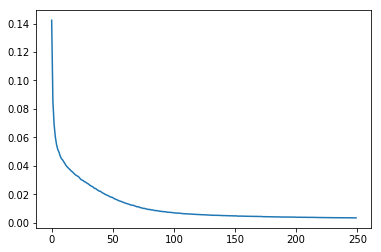

In [172]:
plt.plot(np.arange(len(history)),history)

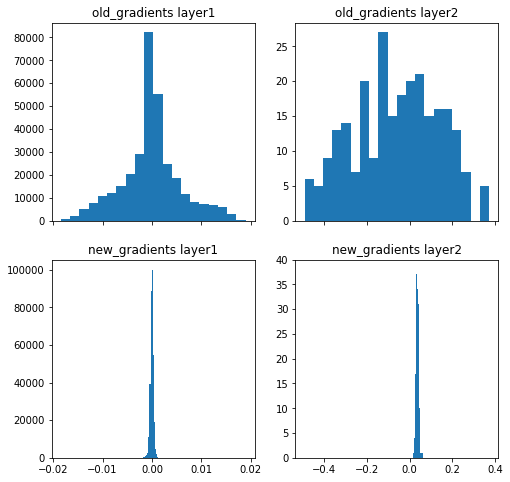

In [167]:
plot_gradients(old_gradients, new_gradients, [0,1])

b) Para el mismo problema definido anteriormente (sección 1) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (loss) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de gradients (link) en el backend de Keras. Deberá generar un histograma para todos los pesos de cada capa antes y despues del entrenamiento con 250 epochs. Comente.

In [75]:
del model
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))

model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.001)
model.compile(optimizer=sgd,loss='mean_squared_error')
###calculate gradients
from keras import backend as K
import tensorflow as tf
#model.fit(X_train_scaled, y_train_scaled)
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
model
evaluated_gradients_before_training = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients_before_training = [gradient/len(y_train) for gradient in evaluated_gradients]

Epoch 1/1
9745/9745 [==============================] - 7s 743us/step - loss: 0.2563


c)  Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.

In [173]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2c.h5')
post_train_model = load_model('post_train_2c.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2c.txt')

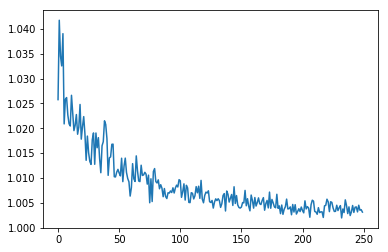

In [175]:
plt.plot(history)

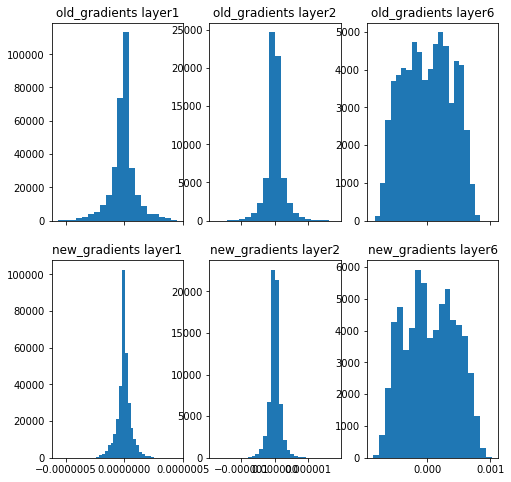

In [177]:
plot_gradients(old_gradients, new_gradients, [0,1,5])

d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.

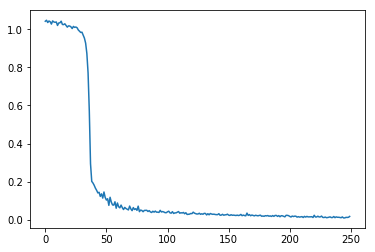

In [179]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2d.h5')
post_train_model = load_model('post_train_2d.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2d.txt')

plt.plot(history)

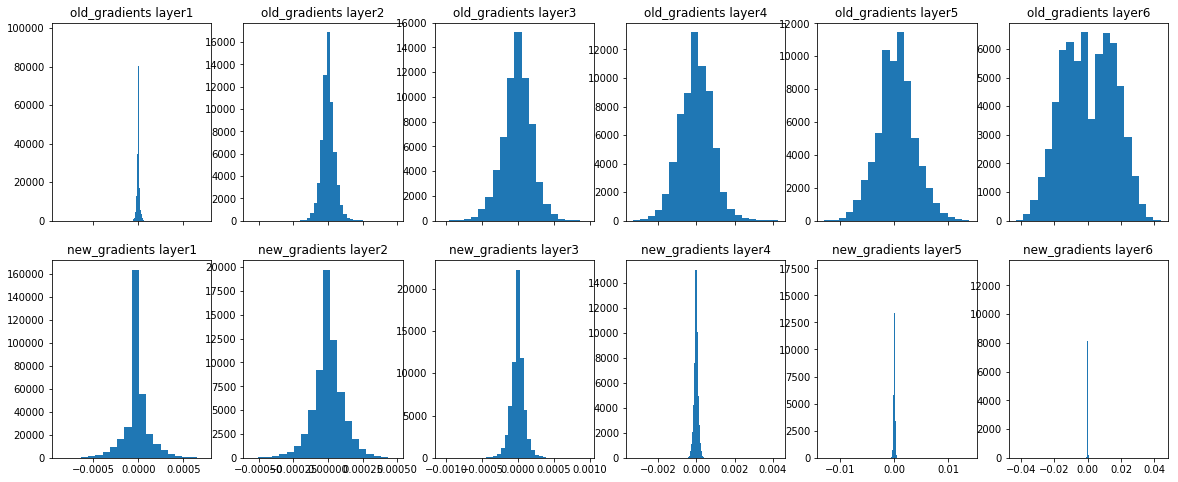

In [183]:
plot_gradients(old_gradients, new_gradients, [0,1,2,3,4,5])

 e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.

Utilizando el learning rate de 0.01, la red diverge

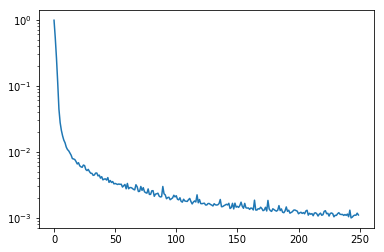

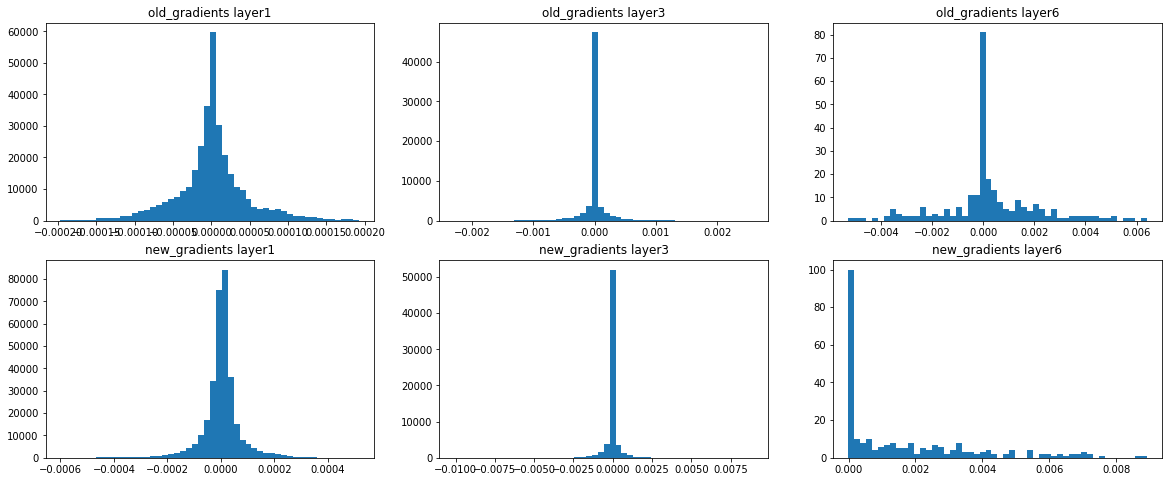

In [242]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2e_uniform.h5')
post_train_model = load_model('post_train_2e_uniform.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2euniform.txt')

plt.semilogy(history)
plot_gradients(old_gradients, new_gradients, [0,2,5])

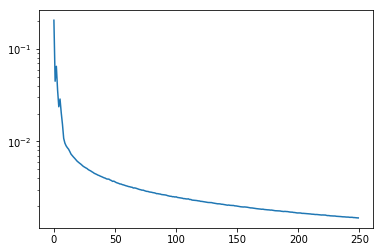

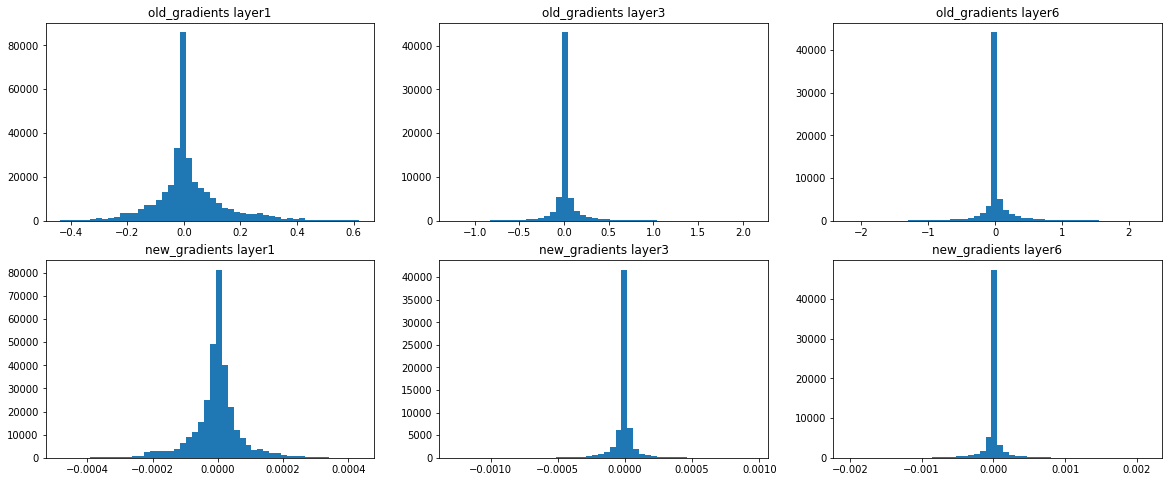

In [240]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2e.h5')
post_train_model = load_model('post_train_2e.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2e.txt')

plt.semilogy(history)
plot_gradients(old_gradients, new_gradients, [0,2,5])

f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

In [243]:
baseline_model = load_model('post_train_2b.h5')

model1 = load_model('post_train_2f_he_uniform_relu_0.01_20.h5')
model2 = load_model('post_train_2f_he_uniform_relu_0.001_50.h5')
model3 = load_model('post_train_2f_he_uniform_relu_0.0005_100.h5')

Modelo con inicialización de **pesos uniforme, activación relu, 100 epochs y un learning rate de 0.00001, en conjunto con el optimizador Adam.**

In [245]:
print(baseline_model.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))
print(model1.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))
print(model2.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))
print(model3.evaluate(X_validation_scaled,y_validation_scaled, verbose = 0))

0.00556677556986659
0.008080263608341734
0.004239855989299972
0.0038002369189038504


Observamos que se alcanza un menor error de validación con el segundo y tercer modelo. Elegimos el **modelo 3** para comparar sobre el test set con el modelo base de 1 capa.

In [247]:
print(baseline_model.evaluate(X_test_scaled,y_test_scaled, verbose = 0))
print(model3.evaluate(X_test_scaled,y_test_scaled, verbose = 0))

0.005365086902257026
0.002082822358948062


 g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.

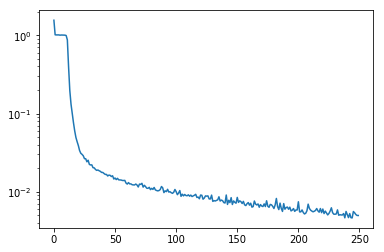

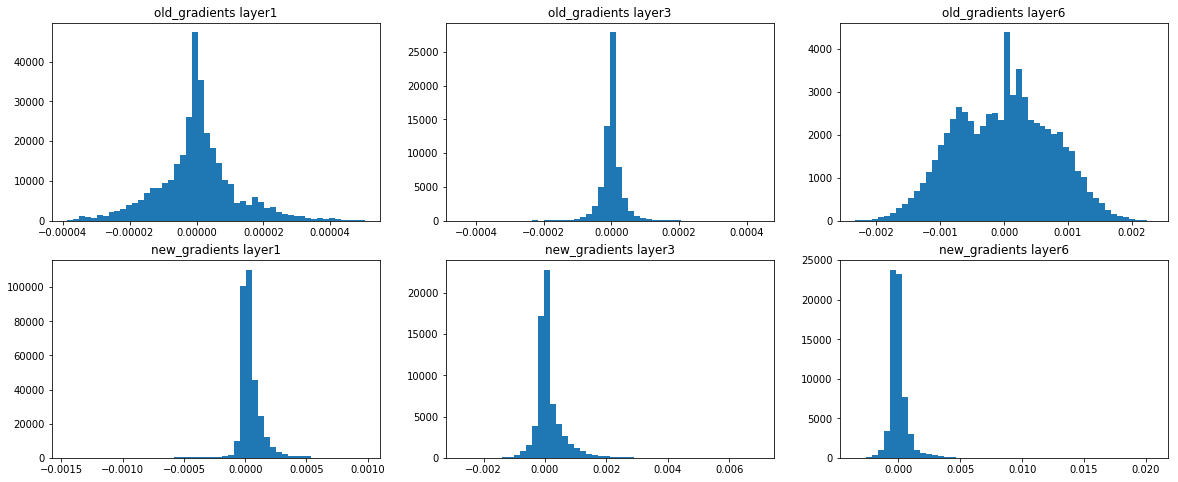

In [248]:
from keras.models import load_model
pre_train_model = load_model('pre_train_2g_uniform.h5')
post_train_model = load_model('post_train_2g_uniform.h5')
old_gradients = compute_gradients(pre_train_model,y_train_scaled)
new_gradients = compute_gradients(post_train_model,y_train_scaled)
history = np.loadtxt('history_2g_uniform.txt')

plt.semilogy(history)
plot_gradients(old_gradients, new_gradients, [0,2,5])

h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?